In [2]:
from google.colab import drive
drive.mount("/content/drive")
# Change working directory
import os
working_dir = "/content/drive/MyDrive/Project"
os.chdir(working_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.3 MB/s eta 0:00:00


In [7]:
# import libraries and packages needed
import os
import datetime

import numpy as np
import pandas

import matplotlib as mpl
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error

In [18]:
# Import wind production data for September 2023
data = pandas.read_csv("./Data/Windparks_September2023.csv", sep=";", index_col=1)
data.index = pandas.to_datetime(data.index, format="%d.%m.%Y %H:%M", dayfirst=True)
data.head(5)

,UTC,Wind parks production,Wind parks production forecast - BRPs,Wind parks production forecast - system operator
Period,,,,
2023-09-01 01:00:00,1693519200,"9,1",5,"11,601"
2023-09-01 02:00:00,1693522800,"10,5",12,"8,889"
2023-09-01 03:00:00,1693526400,"17,4","11,1","11,357"
2023-09-01 04:00:00,1693530000,"19,3","13,8","11,187"
2023-09-01 05:00:00,1693533600,"29,8","13,6","14,251"


In [19]:
# Change the data format to float
wp_prod = data["Wind parks production"].str.replace(",", ".")
wp_prod = wp_prod.astype("float")
wp_forecast_brp = data["Wind parks production forecast - BRPs"].str.replace(",", ".")
wp_forecast_brp = wp_forecast_brp.astype("float")

print(wp_prod.head(5))
print(wp_forecast_brp.head(5))

Period
2023-09-01 01:00:00     9.1
2023-09-01 02:00:00    10.5
2023-09-01 03:00:00    17.4
2023-09-01 04:00:00    19.3
2023-09-01 05:00:00    29.8
Name: Wind parks production, dtype: float64
Period
2023-09-01 01:00:00     5.0
2023-09-01 02:00:00    12.0
2023-09-01 03:00:00    11.1
2023-09-01 04:00:00    13.8
2023-09-01 05:00:00    13.6
Name: Wind parks production forecast - BRPs, dtype: float64


In [20]:
# Search for the optimal orders of the SARIMAX model
# Use the autoarima package

model_autoarima1 = auto_arima(
    wp_prod,
    start_p=1, d=1, start_q=1,
    max_p=5, max_d=2, max_q=5,
    start_P=1, D=1, start_Q=1,
    max_P=3, max_D=2, max_Q=3,
    m=24, max_order=None,
    seasonal=True, stationary=False,
    information_criterion="aic",
    alpha=0.05,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1,
    trend="c",
    maxiter=20
)

print(f"best aic: {model_autoarima1.aic()}")

Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(1,1,1)[24]             : AIC=inf, Time=9.27 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=5916.464, Time=0.31 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=5636.352, Time=6.83 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=7.37 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=5804.222, Time=0.78 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=5534.515, Time=18.03 sec
 ARIMA(1,1,0)(3,1,0)[24]             : AIC=5488.570, Time=39.79 sec
 ARIMA(1,1,0)(3,1,1)[24]             : AIC=inf, Time=57.07 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=28.34 sec
 ARIMA(0,1,0)(3,1,0)[24]             : AIC=5579.497, Time=34.48 sec
 ARIMA(2,1,0)(3,1,0)[24]             : AIC=5489.789, Time=40.85 sec
 ARIMA(1,1,1)(3,1,0)[24]             : AIC=5489.773, Time=43.62 sec
 ARIMA(0,1,1)(3,1,0)[24]             : AIC=5501.704, Time=41.69 sec
 ARIMA(2,1,1)(3,1,0)[24]             : AIC=5491.773, Time=40.49 sec
 ARIMA(1,1,0)(3,1,0)[24] intercept   : AIC=5488.570, Time=37.18 sec

Best

In [21]:
# See model summary
model_autoarima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  720
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 24)   Log Likelihood               -2738.285
Date:                            Mon, 25 Dec 2023   AIC                           5488.570
Time:                                    13:29:16   BIC                           5515.833
Sample:                                09-01-2023   HQIC                          5499.112
                                     - 10-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0579      0.495      0.117      0.907      -0.912       1.028
ar.L1          0.3548      0.028     12.713      0.000       0.300       0.409
ar.S.L24      -0.7680      0.039    -19.900      0.000      -0.844      -0.692
ar.S.L48      -0.5732      0.042    -13.631      0.000      -0.656      -0.491
ar.S.L72      -0.2735      0.039     -7.068      0.000      -0.349      -0.198
sigma2       150.4284      5.710     26.343      0.000     139.236     161.621
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               188.05
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
# Search for the optimal orders of the SARIMAX model
# Use the autoarima package

model_autoarima2 = auto_arima(
    wp_prod,
    start_p=1, d=1, start_q=1,
    max_p=5, max_d=2, max_q=5,
    start_P=1, D=1, start_Q=1,
    max_P=3, max_D=2, max_Q=3,
    m=24, max_order=None,
    seasonal=True, stationary=False,
    information_criterion="aic",
    alpha=0.05,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1,
    trend="t",
    maxiter=20
)

print(f"best aic: {model_autoarima2.aic()}")

Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(1,1,1)[24]             : AIC=5542.197, Time=13.73 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=5916.300, Time=0.30 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=5636.257, Time=10.92 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=7.74 sec
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=5537.354, Time=3.41 sec
 ARIMA(1,1,1)(0,1,0)[24]             : AIC=5802.827, Time=3.12 sec
 ARIMA(1,1,1)(0,1,2)[24]             : AIC=inf, Time=40.92 sec
 ARIMA(1,1,1)(1,1,0)[24]             : AIC=5655.157, Time=9.28 sec
 ARIMA(1,1,1)(1,1,2)[24]             : AIC=inf, Time=27.72 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=inf, Time=9.34 sec
 ARIMA(2,1,1)(0,1,1)[24]             : AIC=inf, Time=10.02 sec
 ARIMA(1,1,2)(0,1,1)[24]             : AIC=inf, Time=12.64 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=inf, Time=7.30 sec
 ARIMA(0,1,2)(0,1,1)[24]             : AIC=inf, Time=9.82 sec
 ARIMA(2,1,0)(0,1,1)[24]             : AIC=inf, Time=10.51 sec
 ARIMA(2,1,2)(0,1,1)[24]         

In [23]:
# See model summary
model_autoarima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  720
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 24)   Log Likelihood               -2760.316
Date:                              Mon, 25 Dec 2023   AIC                           5534.633
Time:                                      13:35:47   BIC                           5566.440
Sample:                                  09-01-2023   HQIC                          5546.932
                                       - 10-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0001      0.001      0.185      0.853      -0.001       0.001
ar.L1          0.1714      4.251      0.040      0.968      -8.161       8.504
ar.L2          0.0401      1.612      0.025      0.980      -3.119       3.199
ma.L1          0.1944      4.242      0.046      0.963      -8.120       8.508
ma.L2          0.0354      0.172      0.206      0.837      -0.302       0.373
ma.S.L24      -0.7853      0.058    -13.630      0.000      -0.898      -0.672
sigma2       240.8796     15.244     15.802      0.000     211.002     270.757
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):               203.00
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               2.06   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Search for the optimal orders of the SARIMAX model
# Use the autoarima package

model_autoarima3 = auto_arima(
    wp_prod,
    start_p=1, d=1, start_q=1,
    max_p=5, max_d=2, max_q=5,
    start_P=1, D=1, start_Q=1,
    max_P=3, max_D=2, max_Q=3,
    m=24, max_order=None,
    seasonal=True, stationary=False,
    information_criterion="aic",
    alpha=0.05,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1,
    trend="ct",
    maxiter=20
)

print(f"best aic: {model_autoarima3.aic()}")

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=5544.561, Time=12.53 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=5917.933, Time=0.84 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=5646.611, Time=11.14 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=11.15 sec
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=5539.693, Time=3.88 sec
 ARIMA(1,1,1)(0,1,0)[24]             : AIC=5804.709, Time=2.63 sec
 ARIMA(1,1,1)(0,1,2)[24]             : AIC=inf, Time=25.27 sec
 ARIMA(1,1,1)(1,1,0)[24]             : AIC=5657.124, Time=9.96 sec
 ARIMA(1,1,1)(1,1,2)[24]             : AIC=inf, Time=31.41 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=inf, Time=10.57 sec
 ARIMA(2,1,1)(0,1,1)[24]             : AIC=inf, Time=12.27 sec
 ARIMA(1,1,2)(0,1,1)[24]             : AIC=inf, Time=12.52 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=inf, Time=9.34 sec
 ARIMA(0,1,2)(0,1,1)[24]             : AIC=inf, Time=10.46 sec
 ARIMA(2,1,0)(0,1,1)[24]             : AIC=inf, Ti

In [25]:
# See model summary
model_autoarima3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  720
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -2763.847
Date:                            Mon, 25 Dec 2023   AIC                           5539.693
Time:                                    13:39:10   BIC                           5566.957
Sample:                                09-01-2023   HQIC                          5550.236
                                     - 10-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3354      0.500     -0.671      0.502      -1.315       0.644
drift          0.0008      0.001      0.711      0.477      -0.001       0.003
ar.L1          0.5393      0.134      4.035      0.000       0.277       0.801
ma.L1         -0.1768      0.145     -1.220      0.223      -0.461       0.107
ma.S.L24      -0.7706      0.060    -12.932      0.000      -0.887      -0.654
sigma2       245.5063     15.366     15.977      0.000     215.389     275.623
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               184.51
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# Fit models
models = [model_autoarima1, model_autoarima2, model_autoarima3]
opti_models = list()
fitted_opti_models = list()
for i, model in enumerate(models):
    params = model.get_params()
    order = params["order"]
    seasonal_order = params["seasonal_order"]
    if i == 0:
      opti_models.append(SARIMAX(wp_prod, order=order, seasonal_order=seasonal_order, trend="c"))
      fitted_opti_models.append(opti_models[i].fit(disp=False))
    elif i == 1:
      opti_models.append(SARIMAX(wp_prod, order=order, seasonal_order=seasonal_order, trend="t"))
      fitted_opti_models.append(opti_models[i].fit(disp=False))
    else:
      opti_models.append(SARIMAX(wp_prod, order=order, seasonal_order=seasonal_order, trend="ct"))
      fitted_opti_models.append(opti_models[i].fit(disp=False))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  w

In [28]:
# Load the test data
data_test = pandas.read_csv("./Data/Windparks_October01.csv", sep=";", index_col=1)
data_test.index = pandas.to_datetime(data_test.index, format="%d.%m.%Y %H:%M", dayfirst=True)
wp_prod_test = data_test["Wind parks production"].str.replace(",", ".")
wp_prod_test = wp_prod_test.astype("float")
wp_forecast_brp_test = data_test["Wind parks production forecast - BRPs"].str.replace(",", ".")
wp_forecast_brp_test = wp_forecast_brp_test.astype("float")

In [30]:
# Predict using the optimal SARIMAX model
forecasts = list()
for i, fitted_model in enumerate(fitted_opti_models):
    forecasts.append(fitted_model.predict(wp_prod_test.index[0],
                                               wp_prod_test.index[-1]))

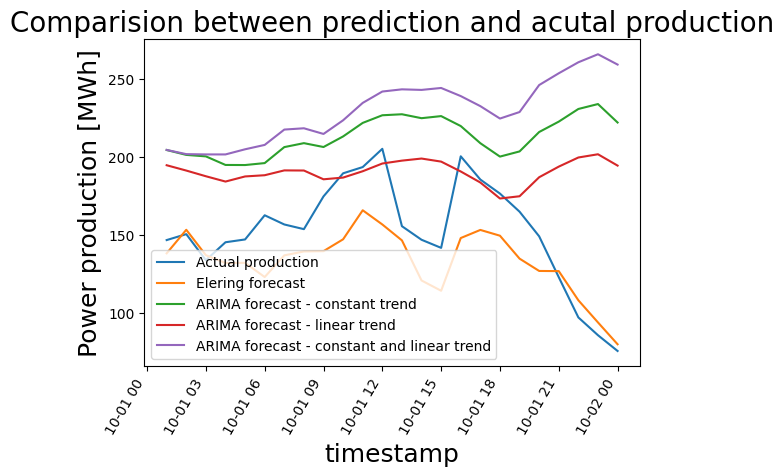

In [31]:
# Plot the prediction results.
fig4 = plt.figure(figsize=(6.4, 4.8))
plt.plot(data_test.index, wp_prod_test, label="Actual production")
plt.plot(data_test.index, wp_forecast_brp_test, label="Elering forecast")
forecasts[0].plot(label="ARIMA forecast - constant trend")
forecasts[1].plot(label="ARIMA forecast - linear trend")
forecasts[2].plot(label="ARIMA forecast - constant and linear trend")
plt.title("Comparision between prediction and acutal production", fontsize=20)
plt.xlabel("timestamp", fontsize=18)
plt.xticks(rotation=60)
mpl.rcParams["xtick.labelsize"] = 16
mpl.rcParams["ytick.labelsize"] = 16
plt.ylabel("Power production [MWh]", fontsize=18)
plt.legend(loc="best")
fig4.savefig("./Data/Figure4.png", bbox_inches="tight")
plt.show()

In [34]:
# Evaluate the prediction by RMSE value.
RMSE_ARIMA = list()
RMSE_ELERING = np.sqrt(mean_squared_error(wp_prod_test, wp_forecast_brp_test))
for i in range(len(forecasts)):
    RMSE_ARIMA.append(np.sqrt(mean_squared_error(wp_prod_test, forecasts[i])))
    print(f"RMSE of ARIMA forecast >> ({RMSE_ARIMA[i]})")
print(f"RMSE of Elering forecast >> ({RMSE_ELERING})")

RMSE of ARIMA forecast >> (71.16612612618307)
RMSE of ARIMA forecast >> (52.36044129664904)
RMSE of ARIMA forecast >> (88.91749419508828)
RMSE of Elering forecast >> (26.185921790152815)
